In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


2024-10-17 10:08:43.407224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 10:08:43.418425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 10:08:43.421833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 10:08:43.998422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


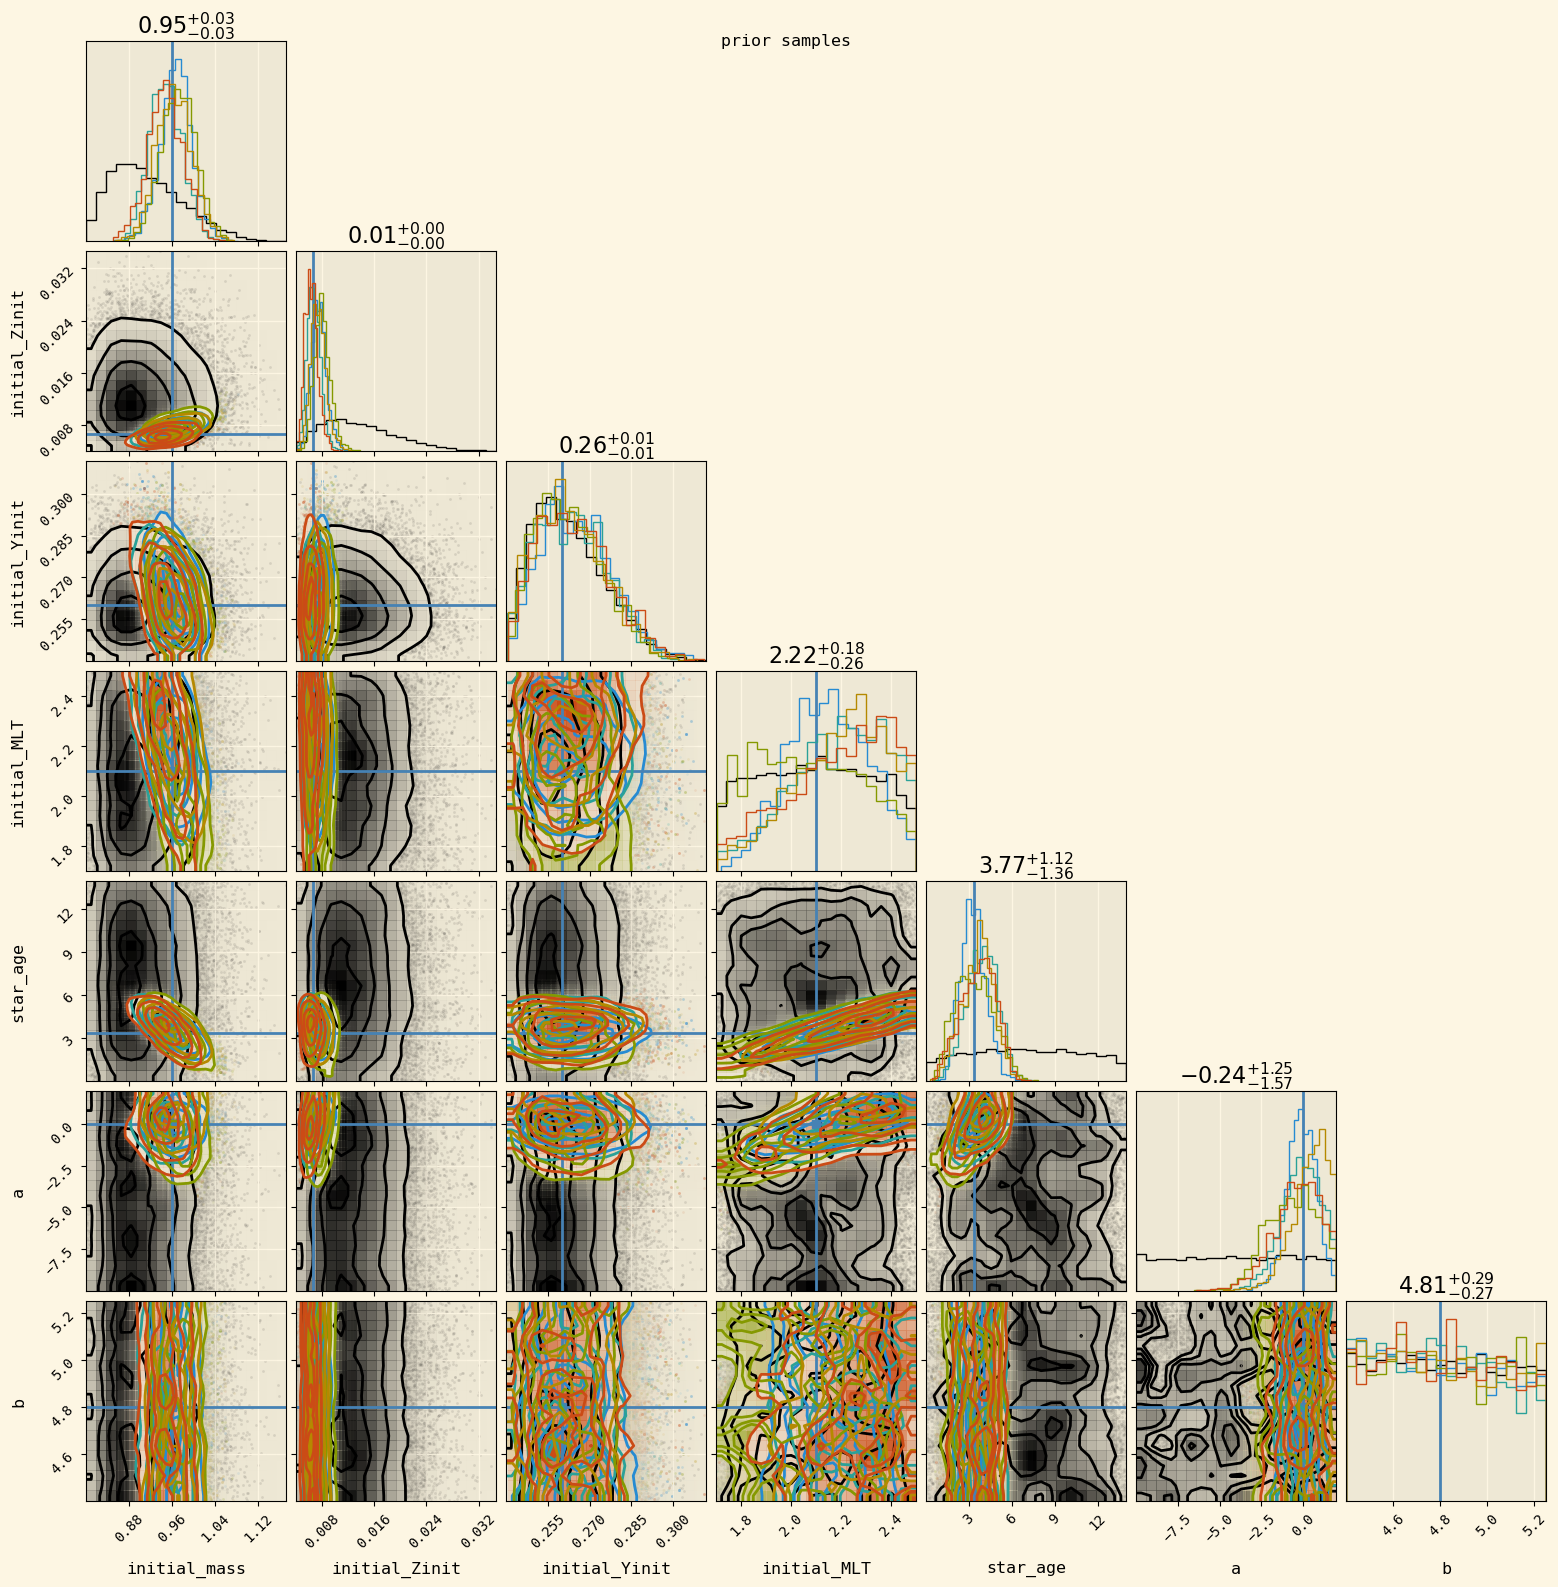

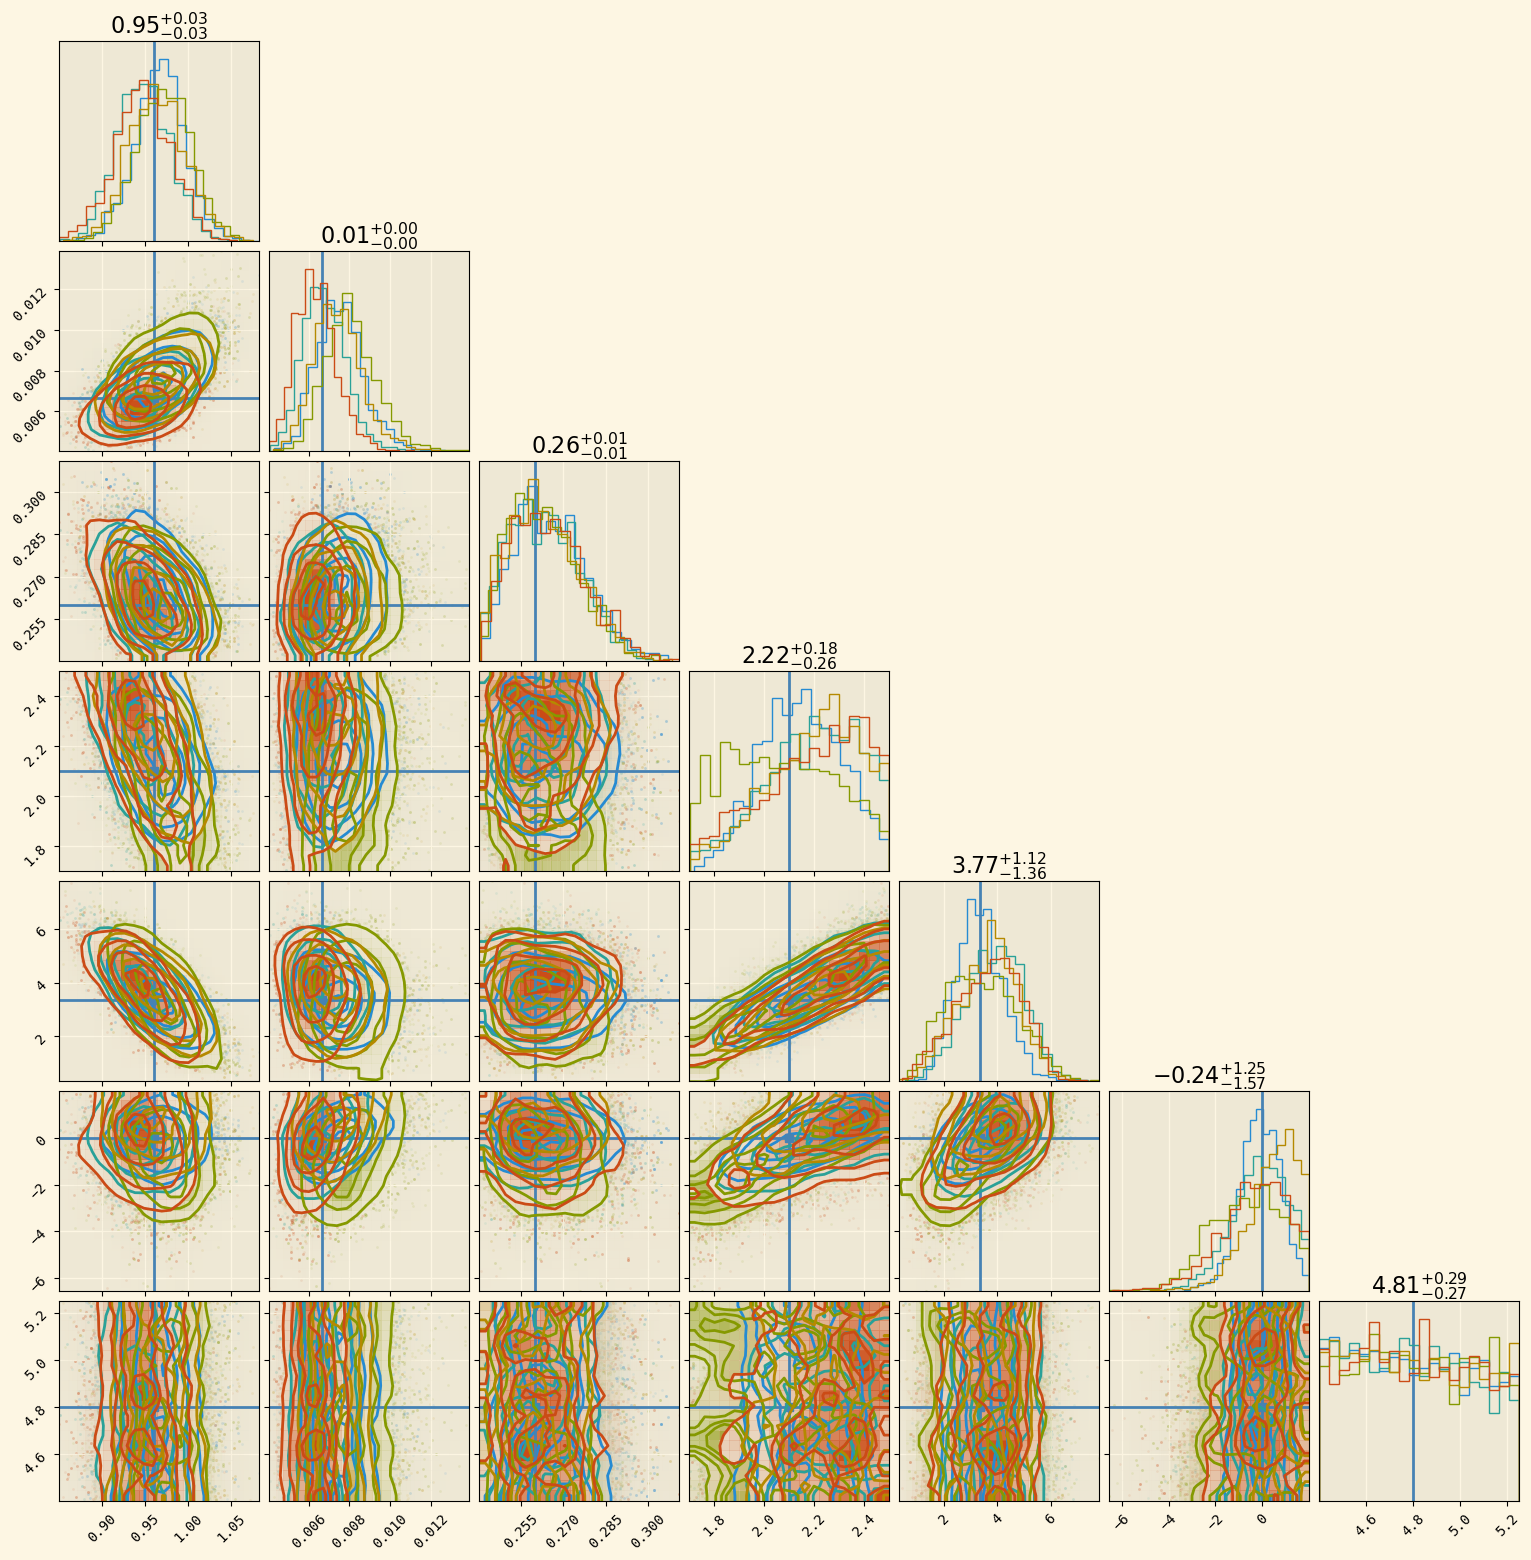

In [12]:
def inspect_emu(emu_idx, obs_idx, z_score_plots=True):
    path = f'nest/emu{emu_idx}'

    if z_score_plots:
        for obs in obs_idx:
            image = plt.imread(path+f'/obs{obs}/zscore_plot.png')
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(image)
            ax.axis('off')

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    i = 0
    for obs in obs_idx:
        emu_df = pd.read_json(path+f'/obs{obs}/obs{obs}.json')[labels]

        with open(path+f'/obs{obs}/samples.pkl', 'rb') as fp:
         samples = pickle.load(fp)
            
        if i == 0:
            corner.corner(samples['samples'], fig=figure, truths = emu_df.values[0], color=colors[i],hist_kwargs={'density':True}, smooth=True,show_titles=True);
            i+=1

        else:
            corner.corner(samples['samples'], fig=figure, color=colors[i],hist_kwargs={'density':True}, smooth=True,show_titles=True);
            i+=1
            
    plt.suptitle('prior samples')
    plt.show()

    i = 0
    
    for obs in obs_idx:
        emu_df = pd.read_json(path+f'/obs{obs}/obs{obs}.json')[labels]

        with open(path+f'/obs{obs}/samples.pkl', 'rb') as fp:
         samples = pickle.load(fp)
            
        if i == 0:
            figure = corner.corner(samples['samples'], truths = emu_df.values[0], color=colors[i],hist_kwargs={'density':True}, smooth=True,show_titles=True);
            i+=1

        else:
            corner.corner(samples['samples'], fig=figure, color=colors[i],hist_kwargs={'density':True}, smooth=True,show_titles=True);
            i+=1
            
    plt.show()

    
inspect_emu(emu_idx=0,obs_idx=[0,1,2,3,4], z_score_plots=False)